## Testing 3 different values of sparsity : 0.2 0.5 and 0.8 PHI2

In [3]:
import numpy as np
data_path1 = "/Users/waelbenslima/Desktop/data/phitwo1.txt"
data1 = np.loadtxt(data_path1)
data_reshaped1 = data1.reshape((1331, 171, 171))

## Sparsity 0.2

Training with sparsity = 0.2
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 694ms/step - loss: 0.0551 - val_loss: 0.0019
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 794ms/step - loss: 0.0015 - val_loss: 9.7428e-04
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 627ms/step - loss: 7.0344e-04 - val_loss: 3.8959e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 29s 845ms/step - loss: 3.8129e-04 - val_loss: 2.9314e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 694ms/step - loss: 4.1986e-04 - val_loss: 2.2928e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 19s 561ms/step - loss: 2.0523e-04 - val_loss: 2.1989e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 617ms/step - loss: 1.9096e-04 - val_loss: 1.5326e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 622ms/step - loss: 1.7846e-04 - val_loss: 1.3732e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 592ms/step - loss: 1.3386e-04 - val_loss: 1.5148e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 650ms/step - loss: 1.2782e-04 - val_loss: 1.1867e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━

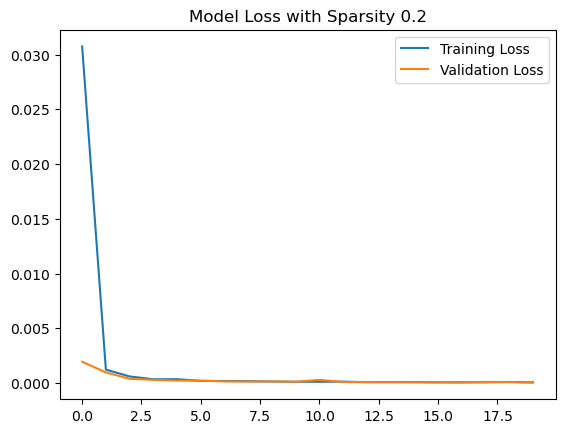

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

# Normalize data
phi2_norm = data_reshaped1 / np.max(data_reshaped1)  # phi2 data

# Define function to generate random masks with different sparsity levels
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Set sparsity value
sparsity = 0.2
print(f"Training with sparsity = {sparsity}")

# Apply masks to phi2 data
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, phi2_norm, masks, test_size=0.2, random_state=42  # Using phi2_norm as target
)

# Define the CNN model for reconstruction of phi2 from masked phi2
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction of phi2
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    [X_train, masks_train], y_train,
    validation_data=([X_test, masks_test], y_test),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Model Loss with Sparsity {sparsity}')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step


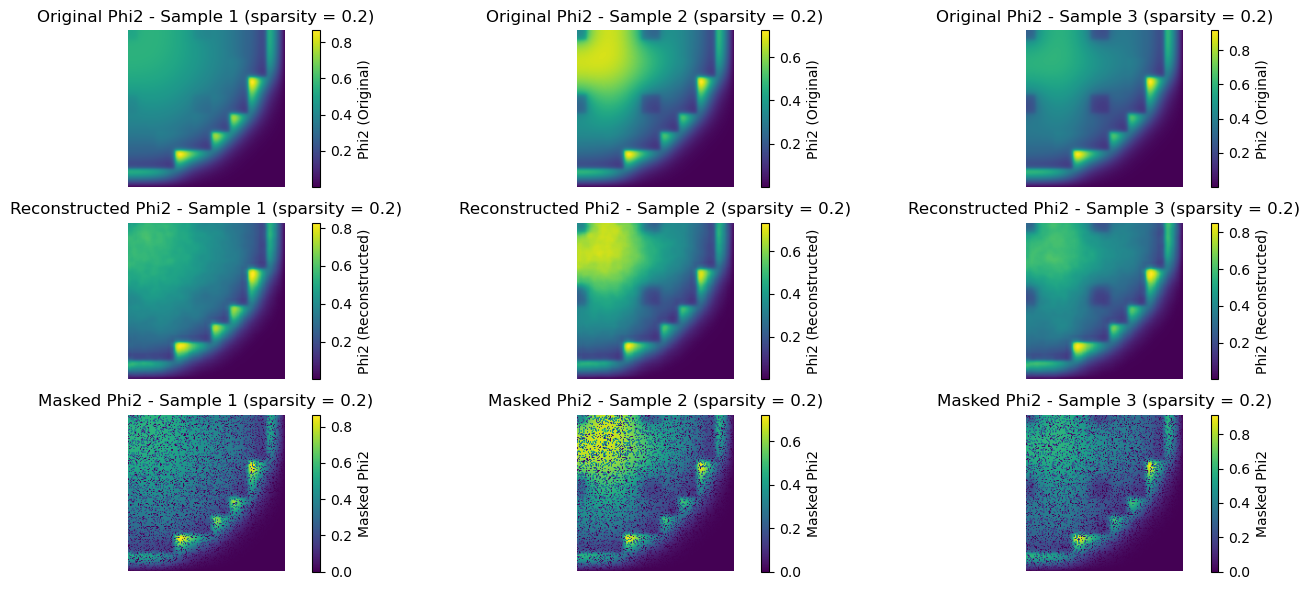

In [12]:
# Predict the output for the noisy input (sparsity = 0.2)
predicted_phi2_002 = model.predict([X_test, masks_test])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi2 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Original)')
    plt.title(f'Original Phi2 - Sample {i+1} (sparsity = 0.2)')
    plt.axis('off')

    # Reconstructed Phi2 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi2_002[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Reconstructed)')
    plt.title(f'Reconstructed Phi2 - Sample {i+1} (sparsity = 0.2)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(X_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sparsity = 0.2)')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [14]:
# Predict the output for the noisy input (sparsity = 0.2)
predicted_phi2_002 = model.predict([X_test, masks_test])

# Flatten the images for metric calculations
y_true_flat = y_test.flatten()  # True phi2 values
y_pred_flat = predicted_phi2_002.flatten()  # Predicted phi2 values

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test[0].reshape(171, 171), predicted_phi2_002[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sigma = 0.2
print(f"Sigma = 0.2:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Sigma = 0.2:
RMSE: 0.0073523597667298135
L∞ Error: 0.12997545016390066
SSIM: 0.9865970088371918
L2 Error: 20.543691793173476
Relative L2 Error: 2.08%


## Sparsity 0.5

Training with sparsity = 0.5
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step - loss: 0.0597 - val_loss: 0.0025
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 617ms/step - loss: 0.0024 - val_loss: 0.0016
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 582ms/step - loss: 0.0012 - val_loss: 7.9404e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 598ms/step - loss: 7.0670e-04 - val_loss: 5.2113e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 590ms/step - loss: 4.9641e-04 - val_loss: 3.4711e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 606ms/step - loss: 3.2755e-04 - val_loss: 3.7201e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 613ms/step - loss: 2.9073e-04 - val_loss: 2.3121e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 686ms/step - loss: 2.2777e-04 - val_loss: 2.2571e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 675ms/step - loss: 1.9653e-04 - val_loss: 1.9809e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 598ms/step - loss: 1.7758e-04 - val_loss: 1.7312e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 2

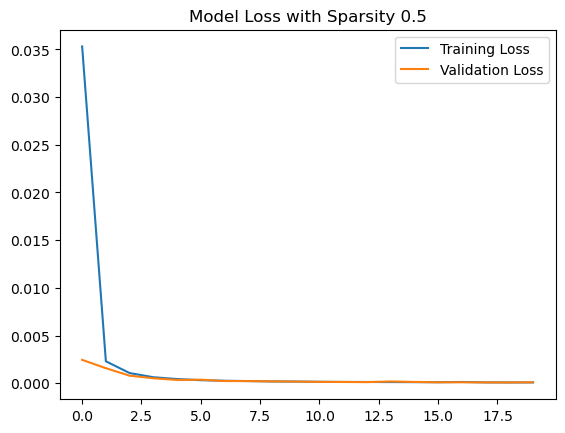

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

# Normalize data
phi2_norm = data_reshaped1 / np.max(data_reshaped1)  # phi2 data

# Define function to generate random masks with different sparsity levels
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Set sparsity value
sparsity = 0.5
print(f"Training with sparsity = {sparsity}")

# Apply masks to phi2 data
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, phi2_norm, masks, test_size=0.2, random_state=42  # Using phi2_norm as target
)

# Define the CNN model for reconstruction of phi2 from masked phi2
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction of phi2
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    [X_train, masks_train], y_train,
    validation_data=([X_test, masks_test], y_test),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Model Loss with Sparsity {sparsity}')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step


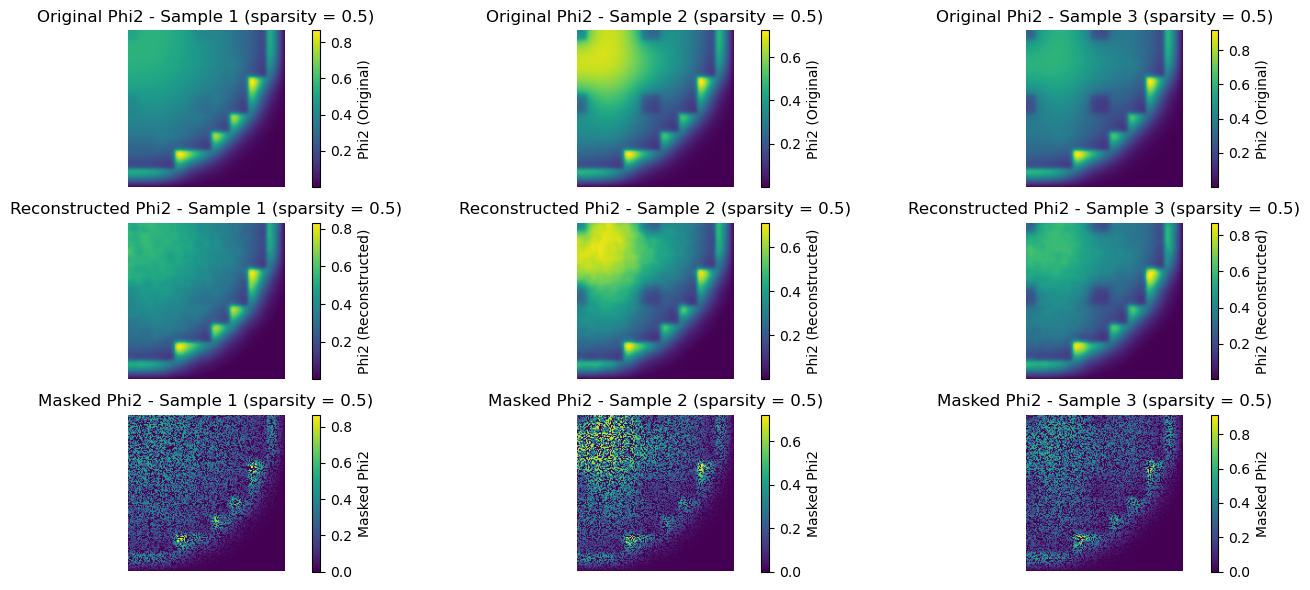

In [19]:
# Predict the output for the noisy input (sparsity = 0.5)
predicted_phi2_005 = model.predict([X_test, masks_test])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi2 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Original)')
    plt.title(f'Original Phi2 - Sample {i+1} (sparsity = 0.5)')
    plt.axis('off')

    # Reconstructed Phi2 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi2_005[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Reconstructed)')
    plt.title(f'Reconstructed Phi2 - Sample {i+1} (sparsity = 0.5)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(X_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sparsity = 0.5)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [21]:
# Predict the output for the noisy input (sparsity = 0.5)
predicted_phi2_005 = model.predict([X_test, masks_test])

# Flatten the images for metric calculations
y_true_flat = y_test.flatten()  # True phi2 values
y_pred_flat = predicted_phi2_005.flatten()  # Predicted phi2 values

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test[0].reshape(171, 171), predicted_phi2_005[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sigma = 0.5
print(f"Sigma = 0.5:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step
Sigma = 0.5:
RMSE: 0.010148686712323284
L∞ Error: 0.1229225234879393
SSIM: 0.9777709416998533
L2 Error: 28.357085145217955
Relative L2 Error: 2.87%
--------------------------------------------------


## Sparsity 0.8

Training with sparsity = 0.8
Epoch 1/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 649ms/step - loss: 0.0593 - val_loss: 0.0025
Epoch 2/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 836ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 3/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 24s 705ms/step - loss: 0.0013 - val_loss: 8.8188e-04
Epoch 4/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 604ms/step - loss: 8.6044e-04 - val_loss: 8.4092e-04
Epoch 5/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 587ms/step - loss: 6.9384e-04 - val_loss: 6.4483e-04
Epoch 6/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 22s 662ms/step - loss: 6.2440e-04 - val_loss: 5.8101e-04
Epoch 7/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 817ms/step - loss: 5.1828e-04 - val_loss: 4.6196e-04
Epoch 8/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 717ms/step - loss: 4.3905e-04 - val_loss: 4.5477e-04
Epoch 9/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 629ms/step - loss: 3.8368e-04 - val_loss: 3.3718e-04
Epoch 10/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 23s 691ms/step - loss: 3.3331e-04 - val_loss: 3.7780e-04
Epoch 11/20
34/34 ━━━━━━━━━━━━━━━━━━━━ 3

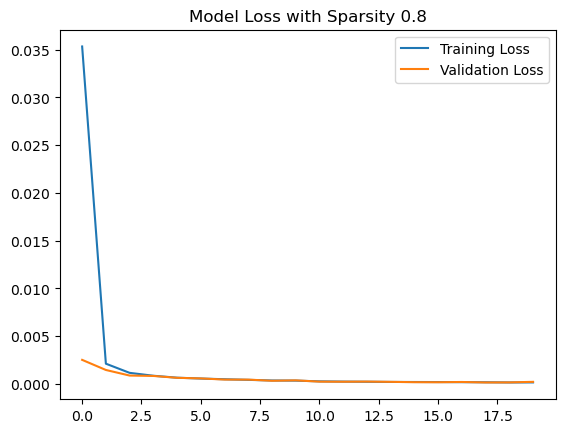

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
from sklearn.model_selection import train_test_split

# Normalize data
phi2_norm = data_reshaped1 / np.max(data_reshaped1)  # phi2 data

# Define function to generate random masks with different sparsity levels
def generate_random_mask(shape, sparsity):
    mask = np.random.choice([0, 1], size=shape, p=[sparsity, 1 - sparsity])
    return mask

# Set sparsity value
sparsity = 0.8
print(f"Training with sparsity = {sparsity}")

# Apply masks to phi2 data
masks = np.array([generate_random_mask(phi2_norm[0].shape, sparsity) for _ in range(len(phi2_norm))])
phi2_masked = phi2_norm * masks

# Split into training and testing sets
X_train, X_test, y_train, y_test, masks_train, masks_test = train_test_split(
    phi2_masked, phi2_norm, masks, test_size=0.2, random_state=42  # Using phi2_norm as target
)

# Define the CNN model for reconstruction of phi2 from masked phi2
input_shape = (171, 171, 1)
mask_input_shape = (171, 171, 1)

phi2_input = layers.Input(shape=input_shape, name="phi2_input")
mask_input = layers.Input(shape=mask_input_shape, name="mask_input")

# Combine masked input
masked_phi2 = layers.Multiply()([phi2_input, mask_input])

# CNN model for reconstruction of phi2
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(masked_phi2)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
output = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Cropping to handle dimensional mismatch
output = layers.Cropping2D(cropping=((0, 1), (0, 1)))(output)

# Create the model
model = models.Model(inputs=[phi2_input, mask_input], outputs=output)
model.compile(optimizer='adam', loss='mse')

# Train the model
history = model.fit(
    [X_train, masks_train], y_train,
    validation_data=([X_test, masks_test], y_test),
    epochs=20,
    batch_size=32
)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Model Loss with Sparsity {sparsity}')
plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 149ms/step


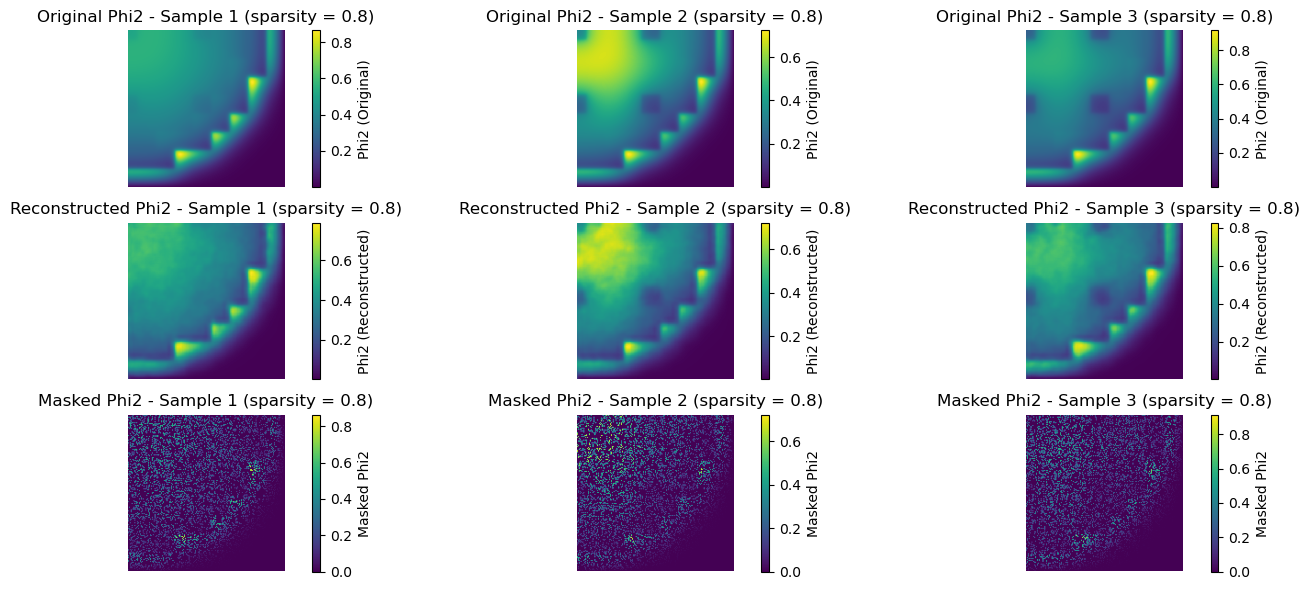

In [25]:
# Predict the output for the noisy input (sparsity = 0.8)
predicted_phi2_008 = model.predict([X_test, masks_test])

# Visualize results
n_samples = 3  # Number of samples to display
plt.figure(figsize=(15, 6))
for i in range(n_samples):
    # Original Phi2 (Ground truth)
    plt.subplot(3, n_samples, i + 1)
    plt.imshow(y_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Original)')
    plt.title(f'Original Phi2 - Sample {i+1} (sparsity = 0.8)')
    plt.axis('off')

    # Reconstructed Phi2 (Predicted)
    plt.subplot(3, n_samples, i + 1 + n_samples)
    plt.imshow(predicted_phi2_008[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Phi2 (Reconstructed)')
    plt.title(f'Reconstructed Phi2 - Sample {i+1} (sparsity = 0.8)')
    plt.axis('off')

    # Masked Phi2 (Input)
    plt.subplot(3, n_samples, i + 1 + 2 * n_samples)
    plt.imshow(X_test[i].squeeze(), cmap='viridis', extent=[0, 171, 0, 171])
    plt.colorbar(label='Masked Phi2')
    plt.title(f'Masked Phi2 - Sample {i+1} (sparsity = 0.8)')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [27]:
# Predict the output for the noisy input (sparsity = 0.8)
predicted_phi2_008 = model.predict([X_test, masks_test])

# Flatten the images for metric calculations
y_true_flat = y_test.flatten()  # True phi2 values
y_pred_flat = predicted_phi2_008.flatten()  # Predicted phi2 values

# 1. Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))

# 2. Calculate L∞ Error (Maximum absolute error)
l_inf_error = np.max(np.abs(y_true_flat - y_pred_flat))

# 3. Calculate SSIM (Structural Similarity Index)
ssim_index = ssim(y_test[0].reshape(171, 171), predicted_phi2_008[0].reshape(171, 171), data_range=1)

# 4. Calculate L2 Error
l2_error = np.linalg.norm(y_true_flat - y_pred_flat)

# 5. Calculate Relative L2 Error
true_l2_norm = np.linalg.norm(y_true_flat)
relative_l2_error = (l2_error / true_l2_norm) * 100  # Convert to percentage

# Print the results for sigma = 0.8
print(f"Sigma = 0.8:")
print(f"RMSE: {rmse}")
print(f"L∞ Error: {l_inf_error}")
print(f"SSIM: {ssim_index}")
print(f"L2 Error: {l2_error}")
print(f"Relative L2 Error: {relative_l2_error:.2f}%")
print("-" * 50)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step
Sigma = 0.8:
RMSE: 0.014949705338949943
L∞ Error: 0.23644959788093278
SSIM: 0.966637294161207
L2 Error: 41.77191386524428
Relative L2 Error: 4.23%
--------------------------------------------------
